In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path

import spacy
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


import scipy.stats as st
import matplotlib.pyplot as plt

from master_thesis.src import utils

pd.set_option('display.max_columns', 80) # make all columns visible

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ruecker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
full = utils.get_raw_df()
#full.set_index('articleId', inplace=True)
#full = full.fillna('')
full.head()

Shared columns: {'publisher', 'date', 'teaser', 'entrances', 'dpaGuid', 'nr_tokens_publisher', 'avgTimeOnPage_percentile', 'rubric', 'zeilen', 'prozentVerlag', 'exits', 'pageviews', 'pagePath', 'avgTimeOnPagePerWordcount', 'article_text', 'nr_tokens_text', 'timeOnPage', 'avgTimeOnPagePerWordcount_percentile', 'category', 'avgTimeOnPage', 'pageviews_percentile', 'bounces', 'prozentDpa', 'language', 'titel'}
Shape of raw df: (107159, 25)


,publisher,date,teaser,entrances,dpaGuid,nr_tokens_publisher,avgTimeOnPage_percentile,rubric,zeilen,prozentVerlag,exits,pageviews,pagePath,avgTimeOnPagePerWordcount,article_text,nr_tokens_text,timeOnPage,avgTimeOnPagePerWordcount_percentile,category,avgTimeOnPage,pageviews_percentile,bounces,prozentDpa,language,titel
articleId,,,,,,,,,,,,,,,,,,,,,,,,,
SZ_16591,SZ,NaN,Coburg Sehr viele Eltern haben eine Vollmacht ...,1382,NaN,535,56.993679,recht,NaN,NaN,1382,2411,NaN,0.088949,Coburg Sehr viele Eltern haben eine Vollmacht ...,535,48968.0,40.812469,sz-spezial,47.587949,90.448376,76,NaN,de,Sparbuch der Kinder ist tabu : Urteil: Vater d...
SZ_16595,SZ,NaN,Berlin Das Verwaltungsgericht Berlin hat entsc...,41,NaN,250,47.765865,recht,NaN,NaN,40,92,NaN,0.163308,Berlin Das Verwaltungsgericht Berlin hat entsc...,250,2123.0,66.788547,sz-spezial,40.826923,3.960089,6,NaN,de,Gewalt in der Schule : Faustschlag ins Gesicht...
SZ_16723,SZ,NaN,Coburg Nicht jeder Rohrbruch ist versichert: B...,308,NaN,231,43.811973,recht,NaN,NaN,308,567,NaN,0.166675,Coburg Nicht jeder Rohrbruch ist versichert: B...,231,9972.0,67.581805,sz-spezial,38.501931,70.071579,26,NaN,de,Abflussrohr der Dachrinne defekt: Gebäudeversi...
SZ_17146,SZ,NaN,Alfons Hewener heiratete erst spät.,38,NaN,785,84.367253,momente,NaN,NaN,36,101,NaN,0.125154,Alfons Hewener heiratete erst spät. Wadgassen....,785,6386.0,55.958726,magazine,98.246154,6.789167,1,NaN,de,„Er war die Liebe meines Lebens“
SZ_17184,SZ,NaN,München Ein Käufer kann erst dann von einem Ka...,125,NaN,398,74.262519,recht,NaN,NaN,124,261,NaN,0.177933,München Ein Käufer kann erst dann von einem Ka...,398,9702.0,70.215667,sz-spezial,70.817518,49.028570,9,NaN,de,Neuer Laptop kaputt - Rücktritt vom Kauf möglich?


In [3]:
len(full.index)

107159

In [4]:
full.publisher.value_counts()

NOZ     36383
SZ      32272
TV      21481
bonn    17023
Name: publisher, dtype: int64

In [6]:
full.language.value_counts() # alle anderen (en und UNKNOWN) wurden rausgefiltert

de    107159
Name: language, dtype: int64

In [7]:
len(full[full.nr_tokens_text <= 5])

0

In [5]:
# Achtung: bei TV und SZ ist Titel nicht im Artikeltext, bei NOZ und bonn schon!!!

## Modelling avgTimeOnPage / avgTimeOnPage_percentile / pageviews with (lemmatized) Bag-of-Words (Ridge Regression)

In [11]:
#full.sort_values(by='avgTimeOnPage', ascending=False)
full.sort_values(by='avgTimeOnPage_percentile', ascending=False)
#full.sort_values(by='avgTimeOnPagePerWordcount', ascending=False)

,prozentDpa,avgTimeOnPage,dpaGuid,nr_tokens_text,avgTimeOnPagePerWordcount,teaser,prozentVerlag,bounces,pageviews,category,entrances,nr_tokens_publisher,language,article_text,avgTimeOnPage_percentile,titel,pagePath,pageviews_percentile,date,exits,timeOnPage,publisher,avgTimeOnPagePerWordcount_percentile,rubric,zeilen
articleId,,,,,,,,,,,,,,,,,,,,,,,,,
SZ_51850689,NaN,425.672897,NaN,779,0.546435,"Völklingen Weniger Stellwände, mehr Arbeiterku...",NaN,67,246,saarland,139,779,de,"Völklingen Weniger Stellwände, mehr Arbeiterku...",100.000000,Neuer Blick auf die Hütte : Völklinger Hütte z...,NaN,46.960213,NaN,139,45547.0,SZ,94.558751,saar-kultur,NaN
NOZ_406939,NaN,3761.362903,NaN,1806,2.082704,"„Du wirst überleben und erzählen, was man mit ...",NaN,468,1522,lokales,1407,1806,de,„Ich war schon auf dem Weg zur Gaskammer“ „Du ...,100.000000,„Ich war schon auf dem Weg zur Gaskammer“,NaN,80.334742,NaN,1398,466409.0,NOZ,99.068267,lathen,NaN
TV_50181851,NaN,362.509091,NaN,453,0.800241,Berlin (ots) Der Bundesverband Deutscher ...,NaN,10,201,pr,146,453,de,Berlin (ots) Der Bundesverband Deutscher Inkas...,100.000000,Bundesverband Deutscher Inkasso-Unternehmen BD...,NaN,45.068423,NaN,146,19938.0,TV,97.970583,presseportal,NaN
bonn_40636111,NaN,674.200000,NaN,209,3.225837,Schülerinnen des Gymnasiums in Pützchen sicher...,NaN,259,505,bonn,334,209,de,Gute Ideen am Sankt-Adelheid-Gymnasium Schüler...,100.000000,Gute Ideen am Sankt-Adelheid-Gymnasium,NaN,55.363330,NaN,335,114614.0,bonn,89.664390,NaN,NaN
NOZ_739925,NaN,2520.174603,NaN,2677,0.941417,Berlin. Ein Gespräch mit RBB-Moderator Jörg Th...,NaN,458,830,deutschland-und-welt,768,2677,de,Fiese Fragen an den Moderator: Jörg Thadeusz: ...,99.997727,Fiese Fragen an den Moderator: Jörg Thadeusz: ...,NaN,69.023271,NaN,767,158771.0,NOZ,90.664485,medien,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bonn_40721187,NaN,0.352273,NaN,378,0.000932,Bonn Nach Vorwürfen gegen zwei aktive Pat...,NaN,1,90,bonn,2,378,de,Collegium Josephinum lässt Vorwürfe prüfen Bon...,0.004950,Collegium Josephinum lässt Vorwürfe prüfen,NaN,4.242154,NaN,2,31.0,bonn,0.009900,NaN,NaN
TV_19380571,NaN,0.760956,NaN,136,0.005595,Trier Bei den Nationalen Spielen von S...,NaN,0,506,region,4,136,de,Trier Bei den Nationalen Spielen von Special ...,0.004655,Sport : Reporter berichten v...,NaN,70.659561,NaN,4,382.0,TV,0.158257,trier-trierer-land,NaN
NOZ_1749974,NaN,6.375661,NaN,522,0.012214,Osnabrück. Der frühere Bundespräsident Christi...,NaN,2,202,deutschland-und-welt,9,522,de,„Wie früher in der Sowjetunion“: Affäre Strach...,0.004545,„Wie früher in der Sowjetunion“: Affäre Strach...,NaN,25.107945,NaN,13,1205.0,NOZ,0.015908,politik,NaN


In [12]:
full.describe().round(2)

,prozentDpa,avgTimeOnPage,nr_tokens_text,avgTimeOnPagePerWordcount,prozentVerlag,bounces,pageviews,entrances,nr_tokens_publisher,avgTimeOnPage_percentile,pageviews_percentile,date,exits,timeOnPage,avgTimeOnPagePerWordcount_percentile,zeilen
count,5695.00,107159.00,107159.00,107159.00,3640.00,107159.00,107159.00,107159.00,107159.00,107159.00,107159.00,5695.00,107159.00,107159.00,107159.00,5695.00
mean,82.88,114.29,483.78,0.32,59.82,290.16,1427.87,786.25,483.78,50.16,49.47,20199207.61,832.82,62953.75,49.76,42.97
std,25.87,103.89,366.42,0.33,17.69,3386.38,7760.87,5091.72,366.42,28.50,28.67,3188.90,5189.76,388214.81,28.41,36.82
min,1.00,0.07,7.00,0.00,1.00,0.00,52.00,0.00,7.00,0.00,0.00,20191106.00,0.00,4.00,0.00,0.00
25%,81.00,41.08,265.00,0.10,51.00,6.00,160.00,62.00,265.00,25.63,24.61,20200203.00,72.00,5980.00,25.32,21.00
50%,96.00,98.97,452.00,0.23,64.00,26.00,312.00,137.00,452.00,49.91,49.23,20200409.00,156.00,15056.00,49.95,34.00
75%,100.00,161.11,636.00,0.42,73.00,105.00,888.00,431.00,636.00,74.67,74.19,20200620.00,479.00,42206.00,74.24,58.00
max,100.00,3761.36,48465.00,10.01,95.00,633004.00,1087521.00,855058.00,48465.00,100.00,100.00,20200923.00,854041.00,53480838.00,100.00,769.00


In [13]:
look_string = "Corona"
mit_string = []
ohne_string = []
#for ID in full.index:
for ID in full[full.publisher == "NOZ"].index:
    if look_string in full.loc[ID, "article_text"]:
        #print("mit string", ID)
        #print(full.loc[ID, "pagePath"])
        
        #print(full.loc[ID, "article_text"][:300])

        mit_string.append(ID)
        
    else:
        #print("ohne string", ID)
        ohne_string.append(ID)
        
print(f"mit String {look_string}: \t {len(mit_string)}")
print(f"ohne String {look_string}: \t {len(ohne_string)}")

mit String Corona: 	 10451
ohne String Corona: 	 25932


In [8]:
df = full
#df = full[full.pageviews - full.exits >= 100]

#df = df[df.publisher == "SZ"]
#df = df[df.publisher == "TV"]
#df = df[df.publisher == "NOZ"]
df = df[df.publisher == "bonn"]



#df = df[df.nr_tokens_text >= 100]
#df = df[df.nr_tokens_text <= 1908]

#df = df[df.avgTimeOnPage >= 5]
#df = df[df.avgTimeOnPage <= 581]

#df = df[df.avgTimeOnPagePerWordcount >= 0.01]
#df = df[df.avgTimeOnPagePerWordcount <= 1.696]


#df = df.sample(frac=1, replace=False, random_state=1) # take 20% for faster processing # TODO: change back


print(df.shape)

(17023, 25)


In [9]:
#creating train, dev, test
#RANDOM_SEED = 123
#df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)
#df_dev, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED, shuffle=True)
#print(df_train.shape, df_dev.shape, df_test.shape)

In [10]:
#publisher = "NOZ"
publisher = "bonn"

df = utils.get_publisher_df(publisher)


with open(utils.OUTPUT / "splits" / f"{publisher}_splits.json", "r") as f:
    splits = json.load(f)
    train_IDs = splits["train"]
    dev_IDs = splits["dev"]
    test_IDs = splits["test"]

df_train = df.loc[train_IDs]
df_dev = df.loc[dev_IDs]
df_test = df.loc[test_IDs]

print(len(df_train), len(df_dev), len(df_test))

FRAC = 0.6
df_train = df_train.sample(frac=FRAC, replace=False, random_state=1)
df_dev = df_dev.sample(frac=FRAC, replace=False, random_state=1)
df_test = df_test.sample(frac=FRAC, replace=False, random_state=1)

print(len(df_train), len(df_dev), len(df_test))

Shape of df: (17023, 29)
13618 1702 1703
8171 1021 1022


In [11]:
# lemmatizes (punctuation stays in, but the default tokenizer from Count_Vectorizer seems to delete it)
class Preprocessor():
    def __init__(self):
        self.nlp = spacy.load("de_core_news_sm", disable=['parser', 'ner'])
        #self.nlp = spacy.load("de_core_news_md", disable=['parser', 'ner'])

    def __call__(self, doc):
        rt = []
        doc = " ".join(doc.split("-")) # necessary for target = 'titel'
        doc = self.nlp(doc)
        for token in doc:
            rt.append(token.lemma_.lower()) # stopwords stay in, but CountVectorizer uses nltk-list later

        return " ".join(rt)

In [12]:
preprocessor = Preprocessor()
stopwords = nltk.corpus.stopwords.words('german')
print(stopwords[:10])
print(len(stopwords))
stopwords = [ preprocessor(s) for s in stopwords ]
print(stopwords[:10])
print(len(stopwords))

['aber', 'alle', 'allem', 'allen', 'aller', 'alles', 'als', 'also', 'am', 'an']
232
['aber', 'all', 'alle', 'alle', 'all', 'alle', 'als', 'also', 'am', 'an']
232


In [13]:
test_sent1 = "Das sind normale Sätze um den Preprocessor zu testen."
test_sent2 = "das-ist-wie-ein-titel-aussieht"
test_sent3 = "Das ist ein weiterer Satz um zu testen. Heute wählt die USA den amerikanischen Präsidenten, oh Schreck."
print(preprocessor(test_sent1))
print(preprocessor(test_sent2))
print(preprocessor(test_sent3))

der sein normale satz um der preprocessor zu testen .
der sein wie einen titel aussehen
der sein einen weit satz um zu testen . heute wählen der usa der amerikanisch präsident , oh schreck .


In [14]:
preprocessor(full.loc['TV_50181851', "article_text"])[:500]

'berlin ( ots ) der bundesverband deutscher inkasso unternehmen ( bdiu ) üben massiv kritik an der heute vom bundeskabinett beschlossen entwurf ein gesetz zur verbesserung der verbraucherschutzes im inkassorecht . ich belasten einseitig der wirtschaft , machen gläubigern der einzug sich forderung in viel fall wirtschaftlich unmöglich und vergesellschaftet so der kosten schlecht zahlungsmoral . der verband rechnen allein für der branche mit einnahmeeinbußen von rund 30 prozent    bei gleichbleiben'

In [15]:
preprocessor = Preprocessor()
vectorizer = CountVectorizer(analyzer='word',
                             preprocessor=preprocessor,
                             ngram_range=(1, 5),
                             min_df=5, # Achtung: vielleicht je nach Textbasis anpassen?
                             max_features=2000,
                             stop_words= stopwords
                            )

In [16]:
"""
preprocessor = Preprocessor()
vectorizer = TfidfVectorizer(analyzer='word',
                             preprocessor=preprocessor,
                             ngram_range=(1, 5),
                             min_df=5, # Achtung: vielleicht je nach Textbasis anpassen?
                             max_features=500,
                             stop_words= stopwords
                            )
                
"""

"\npreprocessor = Preprocessor()\nvectorizer = TfidfVectorizer(analyzer='word',\n                             preprocessor=preprocessor,\n                             ngram_range=(1, 5),\n                             min_df=5, # Achtung: vielleicht je nach Textbasis anpassen?\n                             max_features=500,\n                             stop_words= stopwords\n                            )\n                \n"

In [17]:
#vectorizer.fit([test_sent1, test_sent2, test_sent2, test_sent2, test_sent1, test_sent2, test_sent3, test_sent1])
#print(vectorizer.vocabulary_)

In [18]:
df_train.head()

,pageviews,exits,entrances,bounces,timeOnPage,category,rubric,title,date,titel,prozentDpa,prozentVerlag,zeilen,pagePath,dpaGuid,article_text,titel_html,other_content,teaser,article_body,avgTimeOnPage,nr_tokens_text,avgTimeOnPagePerWordcount,avgTimeOnPage_percentile,pageviews_percentile,avgTimeOnPagePerWordcount_percentile,language,publisher,nr_tokens_publisher
articleId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bonn_43119867,222,138,140,95,12198,region,voreifel-und-vorgebirge,das-leben-ist-jetzt_aid-43119867,NaN,Amélie Schenk im Gespräch : „Das Leben ist jetzt“,NaN,NaN,NaN,NaN,NaN,Amélie Schenk im Gespräch : „Das Leben ist jet...,Amélie Schenk im Gespräch : „Das Leben ist jetzt“,no,Alfter Amélie Schenk ist Ethnologin und l...,"< p class=""text""> Schon vor mehr als 25 Jahren...",145.214286,1079,0.134582,54.950005,32.016632,7.202257,de,bonn,1079
bonn_52167949,514,185,108,56,29990,region,sieg-und-rhein,taxi-stoesst-nach-angriff-auf-fahrer-mit-ander...,NaN,Hennef : Taxi stößt nach Angriff auf Fahrer mi...,NaN,NaN,NaN,NaN,NaN,Hennef : Taxi stößt nach Angriff auf Fahrer mi...,Hennef : Taxi stößt nach Angriff auf Fahrer mi...,no,Hennef. Zu einem Unfall mit zwei Leichtve...,Zuvor hatte der Taxifahrer zwei offensichtlich...,91.155015,200,0.455775,20.587071,55.769231,68.042768,de,bonn,200
bonn_51492493,438,134,56,32,36565,bonn,bad-godesberg,pumpwerk-am-godesberger-bach-wird-modernisiert...,NaN,"Neue Technik für 1,1 Millionen Euro : Pumpwerk...",NaN,NaN,NaN,NaN,NaN,"Neue Technik für 1,1 Millionen Euro : Pumpwerk...","Neue Technik für 1,1 Millionen Euro : Pumpwerk...",no,Plittersdorf Die Abwasser-Querung am Gode...,Beim Überqueren des Godesberger Bachs am Von-S...,120.279605,388,0.309999,36.867637,51.665677,49.762400,de,bonn,388
bonn_48829371,788,398,330,208,71788,region,sieg-und-rhein,hochschule-bonn-rhein-sieg-fuehrt-neuen-studie...,NaN,Teil des „Cyber-Campus Nordrhein-Westfalen“ : ...,NaN,NaN,NaN,NaN,NaN,Teil des „Cyber-Campus Nordrhein-Westfalen“ : ...,Teil des „Cyber-Campus Nordrhein-Westfalen“ : ...,no,Rhein-Sieg-Kreis Die Hochschule Bonn-Rhei...,Die Hochschule Bonn-Rhein-Sieg (H-BRS) ist ein...,184.071795,472,0.389983,79.620830,65.184140,61.553312,de,bonn,472
bonn_50122319,688,234,126,77,47532,region,ahr-und-rhein,landesgartenschau-in-bad-neuenahr-im-fruehsomm...,NaN,Bad Neuenahr-Ahrweiler : Im Frühsommer beginne...,NaN,NaN,NaN,NaN,NaN,Bad Neuenahr-Ahrweiler : Im Frühsommer beginne...,Bad Neuenahr-Ahrweiler : Im Frühsommer beginne...,no,Bad Neuenahr Im Frühsommer sollen teilwei...,Im Zuge der Vorbereitungen für die Landesgarte...,104.696035,513,0.204086,26.932977,62.545788,22.646273,de,bonn,513


In [19]:
# define text base for features: text_preprocessed? titelH1? teaser?

#feature = 'textPublisher_preprocessed'
feature = 'article_text'
#feature = 'titelH1'
#feature = 'teaser'

#feature = 'titel'

X_train = vectorizer.fit_transform(df_train[feature])

In [20]:
#print(vectorizer.get_feature_names()[:50]) # first n-grams
#print(vectorizer.get_feature_names()[-50:]) # last n-grams
vectorizer.vocabulary_

{'gespräch': 789,
 'leben': 1066,
 'alfter': 124,
 'hälfte': 886,
 'jahr': 929,
 'erzählen': 619,
 'land': 1049,
 'text': 1641,
 'schon': 1459,
 'mehr': 1140,
 '25': 48,
 'erst': 607,
 'mal': 1116,
 'seitdem': 1485,
 'regelmäßig': 1372,
 'lässt': 1110,
 'erklären': 592,
 'warum': 1862,
 'buch': 390,
 'einfach': 525,
 'immer': 892,
 'info': 900,
 'person': 1297,
 'wachsen': 1849,
 'beschäftigen': 310,
 'insbesondere': 911,
 'verschieden': 1786,
 'heute': 863,
 'unterwegs': 1723,
 'neben': 1219,
 'betreuen': 332,
 'teilen': 1628,
 'lernen': 1081,
 'kultur': 1026,
 'unterstützung': 1720,
 'klein': 981,
 'führen': 719,
 'studieren': 1600,
 'spät': 1550,
 'ja': 928,
 'ganz': 728,
 'eigentlich': 521,
 'gar': 730,
 'universität': 1710,
 'erleben': 595,
 'vielleicht': 1814,
 'quadratmeter': 1350,
 'welt': 1878,
 'interessieren': 917,
 'geben': 735,
 'unterschied': 1717,
 'dürfen': 506,
 'tragen': 1662,
 'daraus': 442,
 'ende': 549,
 'liegen': 1094,
 'ab': 98,
 'damals': 434,
 'schnellen': 1458

In [21]:
freqs = zip(vectorizer.get_feature_names(), X_train.sum(axis=0).tolist()[0])    
# sort from largest to smallest
print("most frequent:")
print(sorted(freqs, key=lambda x: -x[1])[:50])
#print(sorted(freqs, key=lambda x: -x[1])[-50:])

most frequent:
[('jahr', 15889), ('bonn', 15484), ('sagen', 13521), ('geben', 12303), ('mehr', 9645), ('kommen', 8383), ('gehen', 7402), ('stadt', 7329), ('gut', 7097), ('groß', 6911), ('stehen', 6450), ('seit', 6429), ('schon', 6350), ('erst', 6222), ('euro', 6190), ('bonner', 6074), ('zwei', 6065), ('mensch', 5594), ('corona', 5540), ('uhr', 5507), ('immer', 4927), ('neu', 4825), ('rund', 4825), ('müssen', 4796), ('sehen', 4702), ('ab', 4475), ('tag', 4460), ('finden', 4360), ('kind', 4322), ('polizei', 4180), ('zeit', 4167), ('prozent', 4148), ('bereits', 4142), ('köln', 4122), ('bad', 4059), ('beim', 4000), ('drei', 3999), ('straße', 3900), ('bleiben', 3874), ('wenig', 3832), ('etwa', 3787), ('haus', 3737), ('alt', 3633), ('dabei', 3585), ('mann', 3533), ('rhein', 3494), ('liegen', 3456), ('deutschland', 3425), ('eine', 3398), ('erklären', 3349)]


In [22]:
vectorizer.get_feature_names()[200:220]

['aufs',
 'aufstellen',
 'auftrag',
 'auftreten',
 'auftritt',
 'auge',
 'august',
 'augustin',
 'ausbau',
 'ausbauen',
 'ausbildung',
 'ausbreitung',
 'ausbruch',
 'ausgabe',
 'ausgehen',
 'auskunft',
 'ausland',
 'auslösen',
 'ausnahme',
 'ausreichen']

In [23]:
X_dev = vectorizer.transform(df_dev[feature])
X_test = vectorizer.transform(df_test[feature])

In [25]:
X_train.shape, X_dev.shape, X_test.shape

((8171, 2000), (1021, 2000), (1022, 2000))

In [26]:
X_dev.shape

(1021, 2000)

In [27]:
X_train, X_dev, X_test = X_train.toarray(), X_dev.toarray(), X_test.toarray()

In [28]:
X_train.shape, X_dev.shape, X_test.shape

((8171, 2000), (1021, 2000), (1022, 2000))

In [29]:
X_train[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [30]:
# convert to relative frequencies
X_train_rel = X_train/X_train.sum(axis=1, keepdims=True)
X_dev_rel = X_dev/X_dev.sum(axis=1, keepdims=True)
X_test_rel = X_test/X_test.sum(axis=1, keepdims=True)

# convert to boolean features

X_train_bool = X_train > 0
X_dev_bool = X_dev > 0
X_test_bool = X_test > 0

In [31]:
X_train_rel[:6]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00487805, 0.00487805, ..., 0.        , 0.        ,
        0.        ]])

In [32]:
X_train_bool[:6]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False,  True,  True, ..., False, False, False]])

In [77]:
# append textlength
append_textlength = True # False

if append_textlength == True:
    
    # log-transformed to get smaller dimensions
    X_train_tokens =  np.array(np.log(df_train[['nr_tokens_text']]))
    X_dev_tokens =  np.array(np.log(df_dev[['nr_tokens_text']]))
    X_test_tokens =  np.array(np.log(df_test[['nr_tokens_text']]))

    print(X_train_tokens)
    print(X_train.shape, X_train_tokens.shape)
    
    X_train = np.concatenate((X_train, X_train_tokens), axis=1)
    X_dev = np.concatenate((X_dev, X_dev_tokens), axis=1)
    X_test = np.concatenate((X_test, X_test_tokens), axis=1)

    X_train_rel = np.concatenate((X_train_rel, X_train_tokens), axis=1)
    X_dev_rel = np.concatenate((X_dev_rel, X_dev_tokens), axis=1)
    X_test_rel = np.concatenate((X_test_rel, X_test_tokens), axis=1)

    X_train_bool = np.concatenate((X_train_bool, X_train_tokens), axis=1)
    X_dev_bool = np.concatenate((X_dev_bool, X_dev_tokens), axis=1)
    X_test_bool = np.concatenate((X_test_bool, X_test_tokens), axis=1)

[[6.98378997]
 [5.29831737]
 [5.96100534]
 ...
 [4.78749174]
 [5.64190707]
 [5.29831737]]
(8171, 2000) (8171, 1)


In [78]:
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        6.98378997],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.29831737],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.96100534],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        4.78749174],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.64190707],
       [0.        , 1.        , 1.        , ..., 0.        , 0.        ,
        5.29831737]])

In [79]:
# define the target labels

#target = 'timeOnPage'
#target = 'pageviews'

target = 'avgTimeOnPage'
#target = 'stickiness'
#target = 'bounceRate'

#target = 'avgTimeOnPagePerWordcount'

#target = 'pageviews_percentile'
#target = 'avgTimeOnPage_percentile'
#target = 'avgTimeOnPagePerWordcount_percentile'



y_train = np.array(df_train[target])
y_dev = np.array(df_dev[target])
y_test = np.array(df_test[target])

In [80]:
y_train.shape, y_dev.shape, y_test.shape

((8171,), (1021,), (1022,))

In [81]:
print(st.pearsonr(df.nr_tokens_text, df[target])) # just check correlation with text length

(0.31077214501227773, 0.0)


In [82]:
from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor

In [83]:
# choose model ???
model = Ridge()
#model = LinearRegression()
#model = SGDRegressor()

In [90]:
#model.fit(X_train, y_train)

#model.fit(X_train_rel, y_train)

model.fit(X_train_bool, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [91]:
# predict for dev set

#pred_dev = model.predict(X_dev)

#pred_dev = model.predict(X_dev_rel)

pred_dev = model.predict(X_dev_bool)

In [92]:
# postprocessing: replace negative values with 0 (better way? can I give that hint to the model?)
pred_dev[pred_dev < 0] = 0
pred_dev[:50]

array([147.34836064, 159.51496282, 148.48471481, 200.55064899,
       214.2507539 , 200.8887602 , 136.80276696, 149.60815601,
       129.84637977, 122.85259588, 148.54201473, 185.47400398,
       150.80112259, 249.18189056, 120.59594483,  78.64232708,
        72.99166947, 109.08114582, 170.44983749, 173.52502111,
       143.67644258, 109.73975411, 138.20403841, 153.04667637,
       128.91938438, 145.18915099, 147.62178578, 150.86169673,
       112.97614005, 104.38797482,  97.33732772, 113.51262696,
       123.74480418, 127.40176566, 159.30289641, 170.09877312,
       140.98312202, 204.12812038, 214.57551054, 143.76254188,
       136.84797318, 138.27591299, 201.55435869, 141.38020147,
       174.93059711, 197.92954008, 139.05595043, 100.99380239,
       143.98268675, 162.40178324])

In [93]:
np.array(y_dev)[:50]

array([119.        , 205.33333333, 163.51162791, 137.85840708,
       128.7804878 , 154.16363636,  79.10703954, 100.38181818,
       139.94323873, 129.70503597, 194.93243243, 220.47916667,
       168.72389791, 264.5114079 , 151.44029851, 119.8372093 ,
       100.35842294, 134.85082873,  69.13846154,  91.08044554,
       225.7195122 , 146.71052632, 185.8852459 , 157.09615385,
       134.79646018, 197.44537815, 212.07272727, 128.62868369,
       106.1984127 ,  82.09174312, 103.53846154, 213.79370629,
       180.37699571, 148.59793814, 105.57692308, 132.14814815,
       159.29311678, 125.78947368, 208.278125  , 101.06832298,
        90.02173913, 126.1954023 , 190.46788991, 147.25      ,
       133.84038118, 169.09473684, 168.69605568, 168.19206237,
        58.25409836, 104.6       ])

In [94]:
st.pearsonr(pred_dev, y_dev) # innerhalb der NOZ hier bspw. 0.48
                             # innerhalb der TV hier bspw. 0.3
                             # innerhalb der SZ: 0.41
                             # innerhalb bonn: 0.36
        
        # bei allen kommt man manchmal auf 0.57
        # aber: es wird wohl eher die NOZ als Publisher erkannt, als das wirklich textspezifische Eigenschaften
        # eine Rolle spielen
        
        # relative + textlength bei NOZ 0.50 (höchstes Ergebnis)
        # sonst absolut oder boolean meistens besser
        # noch höher: 300 aber abs + textlength (0.56) 
        # noch höher: 200 aber abs + textlength (0.567)

(0.35847053509591353, 2.549205610916645e-32)

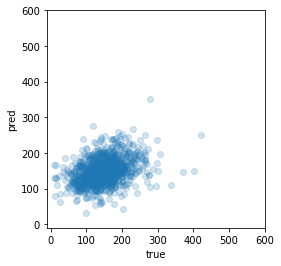

In [95]:
plt.scatter(y_dev, pred_dev, alpha = 0.2)
plt.axis('square')
plt.xlabel("true")
plt.ylabel("pred")


plt.xlim(-10,600)
plt.ylim(-10,600)

#plt.xlim(0,200)
#plt.ylim(0,200)

#plt.xlim(0,1.5)
#plt.ylim(0,1.5)

#plt.xlim(0,200)
#plt.ylim(0,200)

#plt.xlim(0,10)
#plt.ylim(1,10)


plt.show()

In [96]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

In [97]:
mean_squared_error(pred_dev, y_dev) #, squared=False) # hard to interpret

2641.3261628222235

In [98]:
np.sqrt(mean_squared_error(pred_dev, y_dev))

51.3938338988465

In [99]:
mean_absolute_error(pred_dev, y_dev)

39.62211765171925

In [100]:
explained_variance_score(y_dev, pred_dev) # what does this number mean? ... (1.0 is best)

0.01136929729111047

In [101]:
(st.pearsonr(pred_dev, y_dev)[0])**2

0.1285011245319506

In [102]:
# which ID in dev gets biggest value?

pred_max = np.argmax(pred_dev)
print(pred_max)


pred_biggest = pred_dev.argsort()[-8:][::-1] # indices of n biggest valued in pred_dev
print(pred_biggest)

207
[207 424 483 177 474 449  13 945]


In [103]:
for ID in pred_biggest:
    print(ID)
    print("pred:", pred_dev[ID])
    print("true:", y_dev[ID])

207
pred: 350.2049781755068
true: 278.0181818181818
424
pred: 274.8137337451825
true: 117.94545454545455
483
pred: 265.9012836044185
true: 231.3896642776311
177
pred: 259.2727415276426
true: 187.8
474
pred: 252.50457532406494
true: 199.62790697674416
449
pred: 249.80268748818236
true: 421.6489361702128
13
pred: 249.18189056397438
true: 264.511407902059
945
pred: 248.9033932571062
true: 195.3321759259259


In [104]:
for ID in pred_biggest:
    print(ID)
    print(df_dev.index.values[ID])
    
    print("pred:", pred_dev[ID])
    print("true:", y_dev[ID])

    print(df_dev.iloc[ID].avgTimeOnPage)
    print(df_dev.iloc[ID].publisher)
    print(df_dev.iloc[ID].nr_tokens_text)
    print(df_dev.iloc[ID].avgTimeOnPagePerWordcount)

    print(df_dev.iloc[ID].article_text[:500])
    print("---")

207
bonn_44034239
pred: 350.2049781755068
true: 278.0181818181818
278.0181818181818
bonn
3001
0.09264184665717487
Ehemaliger Bundesverfassungsrichter : Interview mit Udo Di Fabio Bonn Als Bundesverfassungsrichter wurde der Bonner Jurist Udo Di Fabio bundesweit bekannt. Doch nicht nur für die Auslegung des Grundgesetzes ist er Experte, sondern auch für schwierige rechtsphilosophische Fragen insgesamt. < p class="text"> Derzeit gibt es zwar viele Veranstaltungen zum Grundgesetz. Doch müsste es in der Breite der Bevölkerung nicht noch viel präsenter sein? Professor Udo Di Fabio: Nicht jeder muss über Detailken
---
424
bonn_42997841
pred: 274.8137337451825
true: 117.94545454545455
117.94545454545455
bonn
1003
0.11759267651590685
Vorsitzender des Bonner Finanzausschusses : Werner Hümmrich fordert härteres Sparen In dieser Woche beginnen die Beratungen des Doppelhaushaltes 2017 und 2018 in den Ratsgremien. Bis zum Beschluss dürfte es bis Jahresende dauern. Schon jetzt ist klar: Es bleibt eng

## Beobachtung

innerhalb eines Publishers scheint das einigermaßen zu funktionieren (corona, jahr, polizei, osnabrück als "spannende" Wörter),

bei allen zusammen gibt es Probleme:

die NOZ hat im Durchschnitt viel längere (dreimal so viel) Aufenthaltsdauer, das Modell lernt dann eher, anhand typischer Floskeln ("Lesen Sie auch:", oder sowas) den Publisher zu erkennen und dem dann pauschal größere Zahlen zu geben...

Grundsätzlich: WARUM hat die NOZ so längere Dauern? Sind da doch noch viele nicht-Text-Inhalte dabei? Wie werde ich die los?

(komisch, jetzt funktioniert es einigermaßen auch zusammen so halbwegs)

Interessant ist jedenfalls, dass "osnabrück", "trier", "saarland" alle drei eher wichtig sind. --> Die Leute interessieren sich für ihre Gegend! Das ist ja wenigstens sinnvoll! :)

## Trying SHAP

In [54]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [55]:
# hier auswählen, auf welchem Set Shap-Werte berechnet und visualisiert werden
explain_set = X_dev
#explain_set = X_dev_rel
#explain_set = X_dev_bool

explain_df = df_dev

In [56]:
explainer = shap.LinearExplainer(model, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(explain_set)

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


In [57]:
explain_set.shape

(1021, 2000)

In [58]:
feature_names=vectorizer.get_feature_names()
feature_names.append("log_textlength")
print(len(feature_names))
print(feature_names[-5:])

2001
['überzeugen', 'üblich', 'übrig', 'übrigens', 'log_textlength']


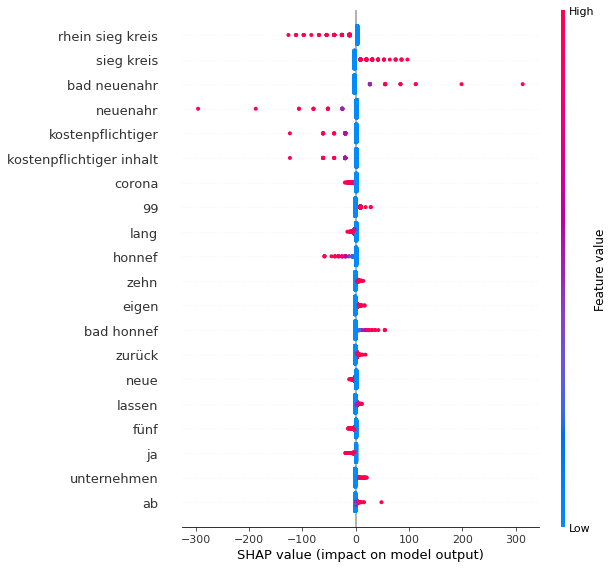

In [59]:
shap.summary_plot(shap_values, explain_set, feature_names=feature_names)

# rot/blau zeigt Feature Value, also rot=Feature ist da/hoch, blau=Feature ist nicht da/niedrig

# ich glaube (bin nicht sicher): nach rechts heißt positiver Einfluss
#                                nach links heißt negativer Einfluss

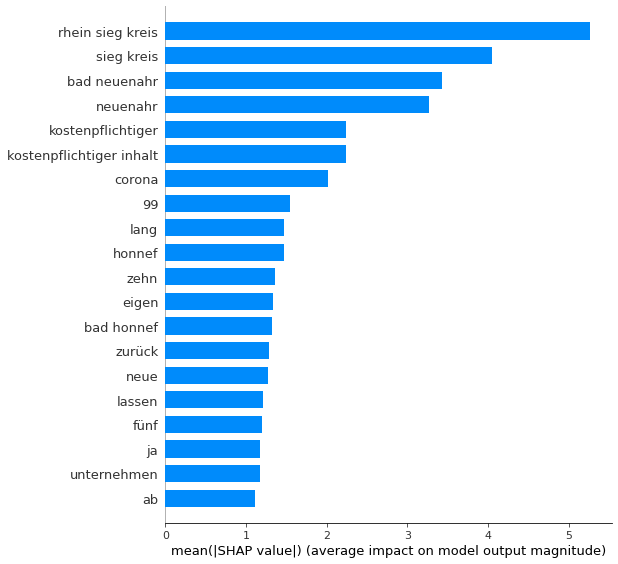

In [60]:
shap.summary_plot(shap_values, explain_set, plot_type="bar", feature_names=feature_names)

In [178]:
#shap.force_plot(explainer.expected_value, 
#                shap_values, 
#                explain_set, 
#                feature_names=feature_names
#               )

# das ordnet die Samples an
# was zeigt das hier genau???

In [179]:
print(pred_biggest)

[1019 1243 2622 3420  638  339 3032 1084]


In [180]:
ind = 1019
shap.force_plot(explainer.expected_value,
                shap_values[ind,:],
                explain_set[ind,:],
                feature_names=feature_names
               )

In [182]:
print(explain_df.iloc[ind].nr_tokens_text)
print(explain_df.iloc[ind].article_text[:2000])

1656
Im NOZ-Interview: Claudia Michelsen - Polizeiruf-Kommissarin mit Gerechtigkeitswahn Berlin. Ihr Name ist ein Qualitätssiegel: Wenn Claudia Michelsen (51) in einem Film mitspielt, kann man ziemlich sicher sein, dass es ein guter ist. Seit sieben Jahren ermittelt sie als Magdeburger Polizeiruf-Kommissarin Doreen Brasch, ab diesem Sonntag allein. Davon und über ihre Kindheit in der DDR spricht sie im Interview: Frau Michelsen, wenn man wie Sie als Tochter einer Zahnärztin aufwächst, hat man dann keine Angst vorm Zahnarzt? Ich habe Riesenangst vorm Zahnarzt oder eher davor, was in meiner Fantasie so alles wehtun könnte. In meiner Erinnerung hatte ich diese Ängste immer schon, eigentlich ganz unbegründet, da ich kaum Probleme mit den Zähnen habe und daher auch sehr unerfahren bin mit all den guten Zahnärzten. Waren Süßigkeiten, Cola, Limo und das ganze Zeugs für Sie als Kind tabu? Nein, diese Verbote gab es nicht. Scheinbar hat bei mir dadurch damals schon unbewusst die Vernunft gesieg

In [183]:
ind = 1243
shap.force_plot(explainer.expected_value,
                shap_values[ind,:],
                explain_set[ind,:],
                feature_names=feature_names
               )

In [184]:
print(explain_df.iloc[ind].nr_tokens_text)
print(explain_df.iloc[ind].article_text[:2000])

1695
Lockdown zu früh?: Corona-Forscher Streeck sieht App, Masken und Massentests skeptisch Bonn. Für den Virologen Hendrik Streeck hat das Covid-19-Virus einen beträchtlichen Teil seines Schreckens verloren. Im Interview mit unserer Redaktion hinterfragt er den Sinn noch bestehender Schutzmaßnahmen und erklärt, warum er sich ein Stück weit bestätigt sieht. Denn: "Nur warnen und mahnen kann man ja sehr leicht." Wer auf den Bonner Venusberg fährt, passiert gemütliche Geschäftsstraßen, gediegene Wohngebiete, schließlich Wälder und Felder. Mitten im Grünen stößt er auf eine komplette Kleinstadt, die im Zeichen der Medizin steht: das Universitätsklinikum Bonn. Es ist nicht nur die Umgebung, die es von der Charité als ihrem berühmten Pendant inmitten der Betonbauten Berlins unterscheidet. Es sind auch die Positionen der jeweiligen Direktoren der Institute für Virologie, die dort Christian Drosten und hier Hendrik Streeck heißen. Wir trafen Streeck zum Interview und Laborbesuch. Herr Prof. D

In [185]:
ind = 722
shap.force_plot(explainer.expected_value,
                shap_values[ind,:],
                explain_set[ind,:],
                feature_names=feature_names
               )

In [186]:
explain_df.iloc[ind].article_text[:300]

'Neuer französischer Premier: Wer ist Jean Castex – und wie spricht man seinen Namen aus? Paris. Frankreich bekommt einen neuen Regierungschef: Auf Édouard Philippe folgt Jean Castex, der weitgehend unbekannt ist. Nach dem Rücktritt der französischen Regierung hat Präsident Emmanuel Macron Jean Caste'

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


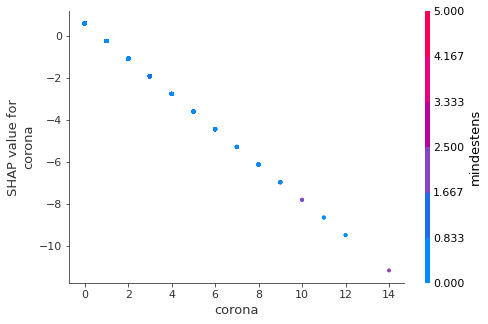

In [187]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("corona", shap_values, explain_set, feature_names=feature_names)

In [ ]:
## trying out relative frequencies

In [89]:
example = ["Birds can fly and birds are great and I love birds.", 
           "Dogs can not fly and birds can.", 
           "This seems enough.",
           "This seems enough. This seems enough."]

In [90]:
vectorizer_test = CountVectorizer()

In [91]:
X_train = vectorizer_test.fit_transform(example)
X_train.toarray()

array([[2, 1, 3, 1, 0, 0, 1, 1, 1, 0, 0, 0],
       [1, 0, 1, 2, 1, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2]])

In [92]:
print(vectorizer_test.get_feature_names())

['and', 'are', 'birds', 'can', 'dogs', 'enough', 'fly', 'great', 'love', 'not', 'seems', 'this']


In [93]:
X_train_rel = X_train / (X_train.sum(axis=1))
X_train_rel.round(2)

array([[0.2 , 0.1 , 0.3 , 0.1 , 0.  , 0.  , 0.1 , 0.1 , 0.1 , 0.  , 0.  ,
        0.  ],
       [0.14, 0.  , 0.14, 0.29, 0.14, 0.  , 0.14, 0.  , 0.  , 0.14, 0.  ,
        0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.33, 0.  , 0.  , 0.  , 0.  , 0.33,
        0.33],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.33, 0.  , 0.  , 0.  , 0.  , 0.33,
        0.33]])

In [94]:
X_train_rel_2 = X_train / (X_train.sum(axis=0))
X_train_rel_2.round(2)

array([[0.67, 1.  , 0.75, 0.33, 0.  , 0.  , 0.5 , 1.  , 1.  , 0.  , 0.  ,
        0.  ],
       [0.33, 0.  , 0.25, 0.67, 1.  , 0.  , 0.5 , 0.  , 0.  , 1.  , 0.  ,
        0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.33, 0.  , 0.  , 0.  , 0.  , 0.33,
        0.33],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.67, 0.  , 0.  , 0.  , 0.  , 0.67,
        0.67]])